In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
#Use "-1" for CPU-only devices

#If working on GPU enviroment
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#Limit the memory allocated by tensorflow to only the necessary amount

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['PYTHONHASHSEED'] = '2'

In [2]:
from os import listdir
from os.path import isfile, join

import numpy as np
from numpy.random import seed
seed(18)

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.random import set_seed
from tensorflow.keras.utils import set_random_seed
set_seed(18)
set_random_seed(18)

import keras

import matplotlib.pyplot as plt

from Supporting_func_file import *

Version_check()

/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.1 when it was built against 1.14.0, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


All packages are using the targeted versions.


## Preparing the data
#### Loading the 30,000 measured samples

In [3]:
#Get the file path to datasets for each acquisition time
main_path = "Data_sets/Performance_evaluation/"

file_paths = [f for f in listdir(main_path) if isfile(join(main_path, f)) and f.endswith(".npz")]

def key_sort(name_):
    return float(name_[23:-12])
file_paths.sort(key=key_sort)
file_paths

['Performance_evaluation_0.1_ms_data.npz',
 'Performance_evaluation_0.3_ms_data.npz',
 'Performance_evaluation_0.5_ms_data.npz',
 'Performance_evaluation_1_ms_data.npz',
 'Performance_evaluation_3_ms_data.npz',
 'Performance_evaluation_5_ms_data.npz',
 'Performance_evaluation_10_ms_data.npz',
 'Performance_evaluation_30_ms_data.npz',
 'Performance_evaluation_50_ms_data.npz',
 'Performance_evaluation_100_ms_data.npz']

#### Generating the mixed state samples for each acquisition time

In [4]:
number_of_repetitions = 20
#The created dataset will consists of (number_of_repetitions * 30000) generated mixed data covering the whole Bloch sphere

radial_positions = Radius_dist((number_of_repetitions, 30000))
#Supporting variable for generating mixed states
#Same across acquisition times to generate the same states

Generating the mixed data will be done in the same fashion as in the "Main_results" notebook, i.e., using the "Generate_mixed_dataset" function stored in "Supporting_func_file" file.

#### Pre-processing the data for the neural network

In [5]:
def Extract_test_set(number_of_repetitions_, data_counts_, data_rhos_):
    #first_borderline = (number_of_repetitions_+1) * 16000
    second_borderline = (number_of_repetitions_+1) * 24000
    
    data_in = Probability_norm(data_counts_)
    data_out = Tau_to_Flat(np.linalg.cholesky(data_rhos_))
    
    seed(18)
    np.random.shuffle(data_in)
    seed(18)
    np.random.shuffle(data_out)
    
    #train_in = data_in[:first_borderline]
    #train_out = data_out[:first_borderline]
    
    #val_in = data_in[first_borderline:second_borderline]
    #val_out = data_out[first_borderline:second_borderline]
    
    test_in = data_in[second_borderline:]
    test_out = data_out[second_borderline:]
    
    return test_in, test_out

Keeping only the test set as we are evaluting a already-trained network.

#### Evaluating the model on a test set

In [6]:
def Evaluate_model(model_, test_in_, test_out_):
    pred_rho = Flat_to_Density(model.predict(test_in_))
    true_rho = Flat_to_Density(test_out_)
    
    fidelity_array = Fidelity(true_rho, pred_rho)
    
    return fidelity_array

In [7]:
model = load_model("Trained_models/Main_results_model.h5", 
                   custom_objects={"fidelity_metric": fidelity_metric})

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 250)               2000      
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 batch_normalization (BatchN  (None, 250)              1000      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 250)               62750     
                                                                 
 dropout_1 (Dropout)         (None, 250)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 250)              1000      
 hNormalization)                                        

We are interested in the fidelity metric between predicted and targeted polarization states.

#### Combining all the previous steps to get test set fidelities for data in filepath

In [8]:
def Analyze_dataset(data_filepath_, model_, number_of_repetitions_, radial_positions_):
    fiber_bundle_counts, input_states_rho = Load_data_file(data_filepath_)
    
    data_rhos, data_counts = Generate_mixed_dataset(input_states_rho, fiber_bundle_counts, radial_positions_)
    
    test_in, test_out = Extract_test_set(number_of_repetitions_, data_counts, data_rhos)
    
    fidelity_array = Evaluate_model(model, test_in, test_out)
    
    fidelity_mean = np.mean(fidelity_array)
    
    fidelity_10_quantile = np.quantile(fidelity_array, 0.10)
    fidelity_90_quantile = np.quantile(fidelity_array, 0.90)
    
    return fidelity_array, fidelity_mean, fidelity_10_quantile, fidelity_90_quantile

In [9]:
#Getting the fidelities for each acqusition time data (= 1/repetition rate)
#This step may take a couple minutes depending on your hardware
acq_fid_means = np.zeros([len(file_paths)])
acq_fid_q10s = np.zeros([len(file_paths)])
acq_fid_q90s = np.zeros([len(file_paths)])

for i, current_path in zip(range(len(file_paths)), file_paths):
    _, acq_fid_means[i], acq_fid_q10s[i], acq_fid_q90s[i] = Analyze_dataset(main_path + current_path, model, number_of_repetitions, radial_positions)

3000/3000 [==============================] - 2s 665us/step


#### Visualizing the results

In [10]:
acq_times = np.array([float(name[23:-12]) for name in file_paths])
rep_rates = 1000 / acq_times

acq_infid_means = 1-acq_fid_means
acq_infid_q10s = 1-acq_fid_q10s
acq_infid_q90s = 1-acq_fid_q90s

_, data_counts = Generate_mixed_dataset(Load_data_file(main_path + "Performance_evaluation_50_ms_data.npz")[1], Load_data_file(main_path + "Performance_evaluation_50_ms_data.npz")[0], radial_positions)
rescaling_counts = int(data_counts.sum(axis=-1).mean().round())

/tmp/ipykernel_4105501/3788975559.py:26: RuntimeWarning: divide by zero encountered in divide
  reps = 1000 / acq                                 #number of repetitions per second


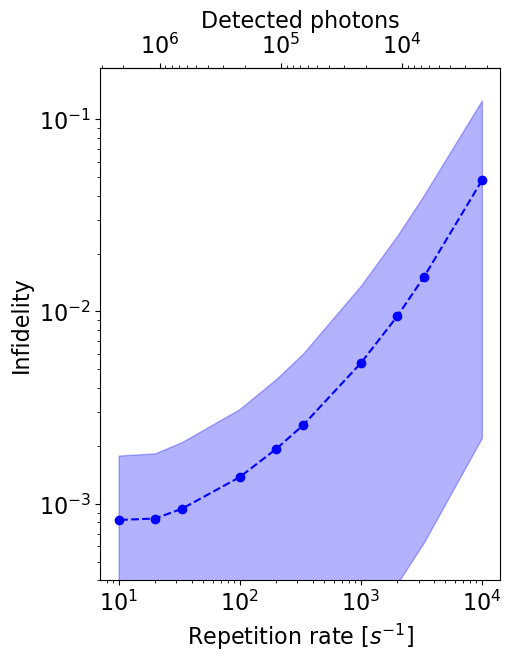

In [11]:
plt.rc('font', size=16)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=16)
plt.rc('figure', titlesize=16)

fig, ax = plt.subplots(constrained_layout=True)
fig.set_size_inches(5, 6.5)

ax.loglog(rep_rates, acq_infid_means, color="blue", linestyle="--")
ax.fill_between(rep_rates, acq_infid_q90s, acq_infid_q10s, color="blue", alpha=0.3)
ax.scatter(rep_rates, acq_infid_means, color="blue")

ax.set_xlabel("Repetition rate [$s^{-1}$]")
ax.set_ylabel("Infidelity")

def forward(reps_):
    acq = 1000 / reps_                                #acq time in ms
    counts = acq * (rescaling_counts / 50)            #acq time in ms * counts per ms = counts per acq time
    return counts

def inverse(counts_):
    acq = counts_ / (rescaling_counts / 50)           #acq time in ms
    reps = 1000 / acq                                 #number of repetitions per second
    return reps

secax = ax.secondary_xaxis('top', functions=(forward, inverse))
secax.set_xlabel("Detected photons")

plt.ylim(bottom=4*10**(-4))
plt.show()